## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm.notebook import tqdm
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Importing the data

In [3]:
path_train = os.listdir("Training/")
path_test = os.listdir("Training/")

In [4]:
def get_images(pth,test_train = "Training/"):
    classes = {"no_tumor" : 0, "pituitary_tumor":1, "meningioma_tumor":2, "glioma_tumor":3}
    x = []
    y = []
    
    for cls in classes:
        pth = test_train + cls
        for i in os.listdir(pth):
            img = cv2.imread(pth+"/"+i, 0)
            img = cv2.resize(img, (200,200))
            x.append(img)
            y.append(classes[cls])
    return x, y

In [5]:
def preprocess_images(images, labels):
    return np.array(images), np.array(labels)

x_train, y_train = get_images(path_train, "Training/")
x_test, y_test = get_images(path_test, "Testing/")

x_train, y_train = preprocess_images(x_train, y_train)
x_test, y_test = preprocess_images(x_test, y_test)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2870, 200, 200)
(2870,)
(394, 200, 200)
(394,)


In [7]:
print(np.unique(y_train), np.unique(y_test))

[0 1 2 3] [0 1 2 3]


In [8]:
pd.Series(y_train).value_counts()

1    827
3    826
2    822
0    395
Name: count, dtype: int64

In [9]:
x_train.shape

(2870, 200, 200)

## Visuilazation of data

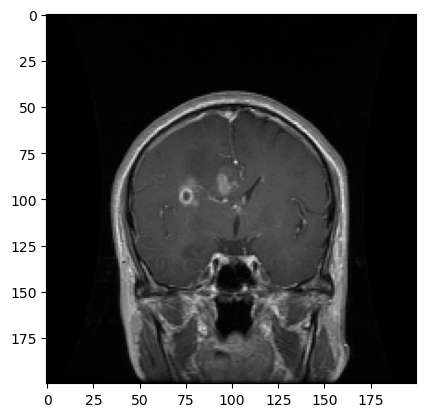

In [10]:
plt.imshow(x_train[2700], cmap = "gray")

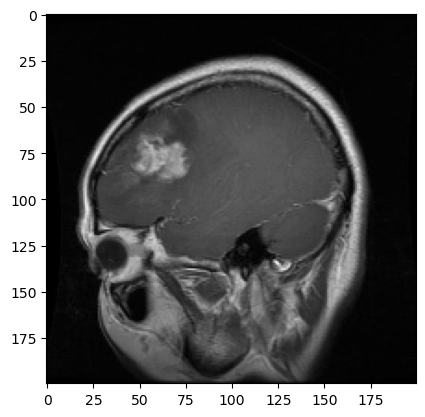

In [11]:
plt.imshow(x_train[2500], cmap = "gray")

# Preprocessing of the data

### Flattening of the data

In [12]:
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

In [13]:
x_train.shape,x_test.shape

((2870, 40000), (394, 40000))

### Feature scaling

In [14]:
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())
x_train = x_train/255
x_test=x_test/255
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

255 0
255 0
1.0 0.0
1.0 0.0


### Feature Selection: PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(.98,random_state=0)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)

In [17]:
print(pca_train.shape, pca_test.shape)

(2870, 1505) (394, 1505)


## Train Model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

def models(x, y):
    # Training of the Logistic Regression model
    log = LogisticRegression(C= 0.1, random_state=42)
    log.fit(x, y)
    
    # Training of the KNN model
    knn = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski")
    knn.fit(x, y)
    
    # Training of the Linear SVM model
    svm1 = LinearSVC(random_state = 42)
    svm1.fit(x, y)
    
    # Training of the RBF Kernel SVM model
    kernel_svm = SVC(kernel = "rbf", random_state = 42, C = 0.1)
    kernel_svm.fit(x, y)
    
    # Training of the Naive Bayes
    naive = GaussianNB()
    naive.fit(x, y)
    
    # Training of the Decision Tree model
    dtree = DecisionTreeClassifier(criterion = "gini", random_state = 42)
    dtree.fit(x, y)
    
    # Training of the Random Forest model
    rforest = RandomForestClassifier(max_depth=70, n_estimators = 1000, criterion = "gini" ,max_features='sqrt',random_state = 42)
    rforest.fit(x, y)
    
    print('[0]Logistic Regression Training Accuracy:', log.score(x, y))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(x, y))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svm1.score(x, y))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', kernel_svm.score(x, y))
    print('[4]Gaussian Naive Bayes Training Accuracy:', naive.score(x, y))
    print('[5]Decision Tree Classifier Training Accuracy:', dtree.score(x, y))
    print('[6]Random Forest Classifier Training Accuracy:', rforest.score(x, y))
    
    return log, knn, svm1, kernel_svm, naive, dtree, rforest

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

model = models(pca_train, y_train)

[0]Logistic Regression Training Accuracy: 0.8937282229965157
[1]K Nearest Neighbor Training Accuracy: 0.8926829268292683
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.9996515679442509
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.7425087108013937
[4]Gaussian Naive Bayes Training Accuracy: 0.5533101045296167
[5]Decision Tree Classifier Training Accuracy: 1.0
[6]Random Forest Classifier Training Accuracy: 0.9996515679442509


## Test Model

In [20]:
def plot_test_results(path,model):
    dec = {0:"No tumor", 1:"Pituitary tumor", 2: "Meningioma tumor", 3:"Glioma tumor"}
    plt.figure(figsize = (8,8))
    c = 1
    for i in os.listdir("Testing/"+path)[:9]:
        plt.subplot(3, 3, c)

        img = cv2.imread("Testing/"+path+i,0)
        img1 = cv2.resize(img, (200,200))
        img1 = img1.reshape(1, -1)/255
        p = model.predict(pca.transform(img1))
        plt.title(dec[p[0]])
        plt.imshow(img, cmap = "bone")
        plt.axis("off")
        c+=1

**Models choosen randomly**

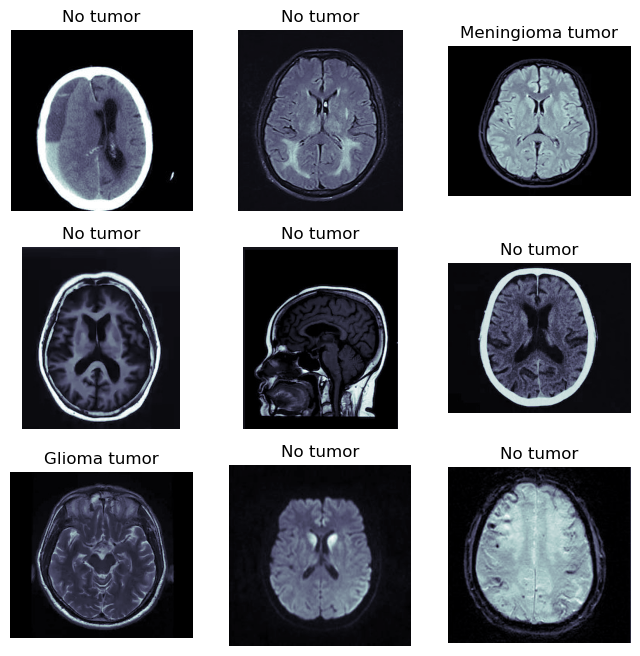

In [21]:
plot_test_results("no_tumor/", model[0])

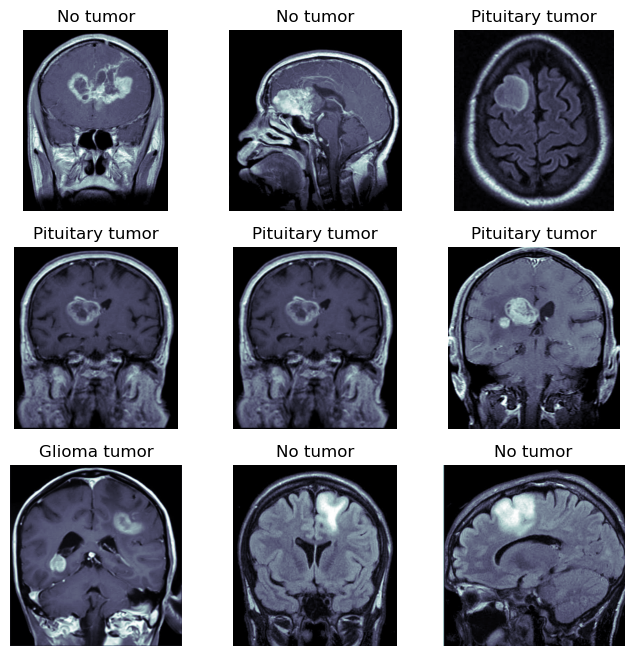

In [22]:
plot_test_results("glioma_tumor/", model[1])

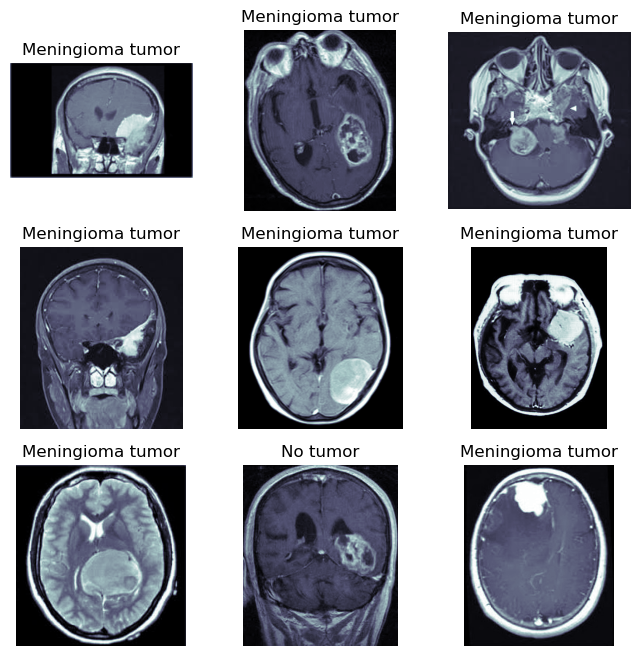

In [23]:
plot_test_results("meningioma_tumor/",model[3])

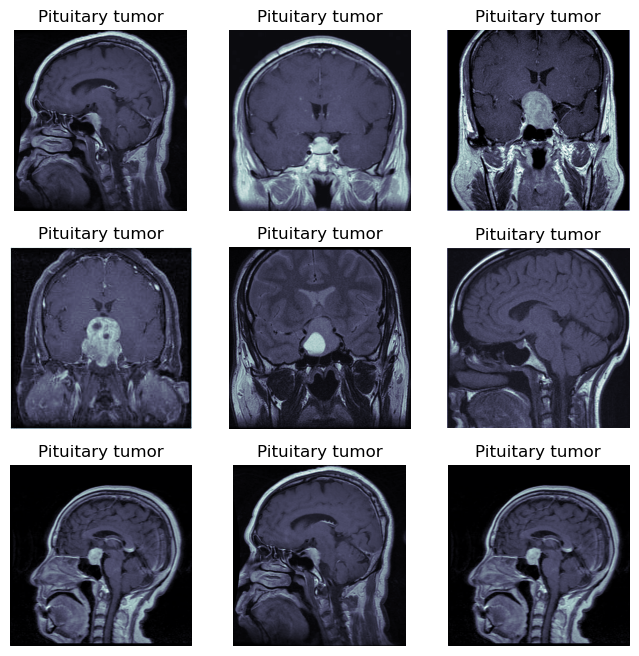

In [24]:
plot_test_results("pituitary_tumor/",model[5])

## Evaluation

In [25]:
for i in tqdm(range(len(model))):
    print(confusion_matrix(y_test, model[i].predict(pca_test)))
    print("Model[{}] Testing Accuracy".format(i),accuracy_score(y_test, model[i].predict(pca_test)))
    print("Model[{}] Testing Precision".format(i),precision_score(y_test, model[i].predict(pca_test), average='micro'))
    print("Model[{}] Testing Recall".format(i),recall_score(y_test, model[i].predict(pca_test), average='micro'))      
    print()

  0%|          | 0/7 [00:00<?, ?it/s]

[[90  2  5  8]
 [ 7 46 20  1]
 [19  8 84  4]
 [44 12 25 19]]
Model[0] Testing Accuracy 0.6065989847715736
Model[0] Testing Precision 0.6065989847715736
Model[0] Testing Recall 0.6065989847715736

[[86  7  3  9]
 [ 7 53  5  9]
 [50 21 40  4]
 [49 19  8 24]]
Model[1] Testing Accuracy 0.5152284263959391
Model[1] Testing Precision 0.5152284263959391
Model[1] Testing Recall 0.5152284263959391

[[105   0   0   0]
 [  7  54  13   0]
 [  3   0 109   3]
 [ 39  12  22  27]]
Model[2] Testing Accuracy 0.748730964467005
Model[2] Testing Precision 0.748730964467005
Model[2] Testing Recall 0.748730964467005

[[ 38  18  32  17]
 [  7  35  26   6]
 [  3   7 103   2]
 [ 25  13  45  17]]
Model[3] Testing Accuracy 0.48984771573604063
Model[3] Testing Precision 0.48984771573604063
Model[3] Testing Recall 0.48984771573604063

[[56 10 17 22]
 [15 40 10  9]
 [78  7 27  3]
 [ 2 36 35 27]]
Model[4] Testing Accuracy 0.38071065989847713
Model[4] Testing Precision 0.38071065989847713
Model[4] Testing Recall 0.3807